In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
import rebound
import seaborn as sns
from astropy import units as u

sol_to_earth = 332946.078
G = 6.6743* 10**(-11) #N⋅m2/kg2
M_sun = 1.989e+33 #g
AU = 1.496e+13 #cm

In [2]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   #'text.usetex': False, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

#Color-blind friendly pallete
colors = [
    "#0C7BDC",  # Vibrant Blue
    "#E66100",  # Bright Orange
    "#40B0A6",  # Teal/Aqua
    "#8B8D8B",  # Medium Grey
    "#5D3A9B"   # Muted Purple
]

vib_blue = "#0C7BDC"
teal = "#40B0A6"
purple = "#5D3A9B" 

In [3]:
solar_system_df = pd.read_csv('../evolved_planets/solarsystem.csv')
mercury = solar_system_df[solar_system_df['name'] == 'Mercury']
venus = solar_system_df[solar_system_df['name'] == 'Venus']
earth = solar_system_df[solar_system_df['name'] == 'Earth']
mars = solar_system_df[solar_system_df['name'] == 'Mars']

In [4]:
#Need to get radii to get theta
def get_radius_from_density_mass(mass, density):
    """
    Calculate the radius of a sphere given its mass and density.

    Parameters:
        mass (float): Mass of the sphere (in kg or g, consistent with density units)
        density (float): Density of the sphere (in kg/m^3 or g/cm^3)

    Returns:
        float: Radius of the sphere (in same length units as density)
    """
    volume = mass / density
    radius = (3 * volume / (4 * np.pi)) ** (1/3)
    return radius

In [5]:
rho = 5.05e6 #(M_sol/AU**3), equals 3 g/cm^3

def get_theta(b_rt, mt, mp, rho):
    rt = get_radius_from_density_mass(mt, rho)
    rp = get_radius_from_density_mass(mp, rho)
    sin_theta = b_rt * (rt / (rp+rt))
    theta = np.rad2deg(np.arcsin(sin_theta))
    return theta

In [6]:
base_path = "../../../data/cham_bench"

coll_stats_list = []
for i in range(30):
    df = rr.extract_data_outfile_full(base_path + f"/cham_bench_{i+1}/slurm.out")
    df['sim_id'] = i + 1
    # Convert all columns except 'type' to float
    for col in df.columns:
        if col != 'type':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df['theta'] = get_theta(df['b/Rt'], df['Mt'], df['Mp'], rho)
    df['Mt'] = df['Mt'] * sol_to_earth
    df['Mp'] = df['Mp'] * sol_to_earth
    coll_stats_list.append(df)

coll_stats_df = pd.concat(coll_stats_list)
coll_stats_df = coll_stats_df[(coll_stats_df['Mt'] <= 20) & (coll_stats_df['Mp'] <= 20)]

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountere

In [7]:
#Mercury forming event ranges in Franco et al (2022)

Mt_range = [0.1, 1] #M_Earth
Mp_range = [0.055, 0.3] #M_Earth
Vi_range = [2, np.max(coll_stats_df['Vimp/Vesc'])] #Vesc
theta_range = [10, 75] #deg

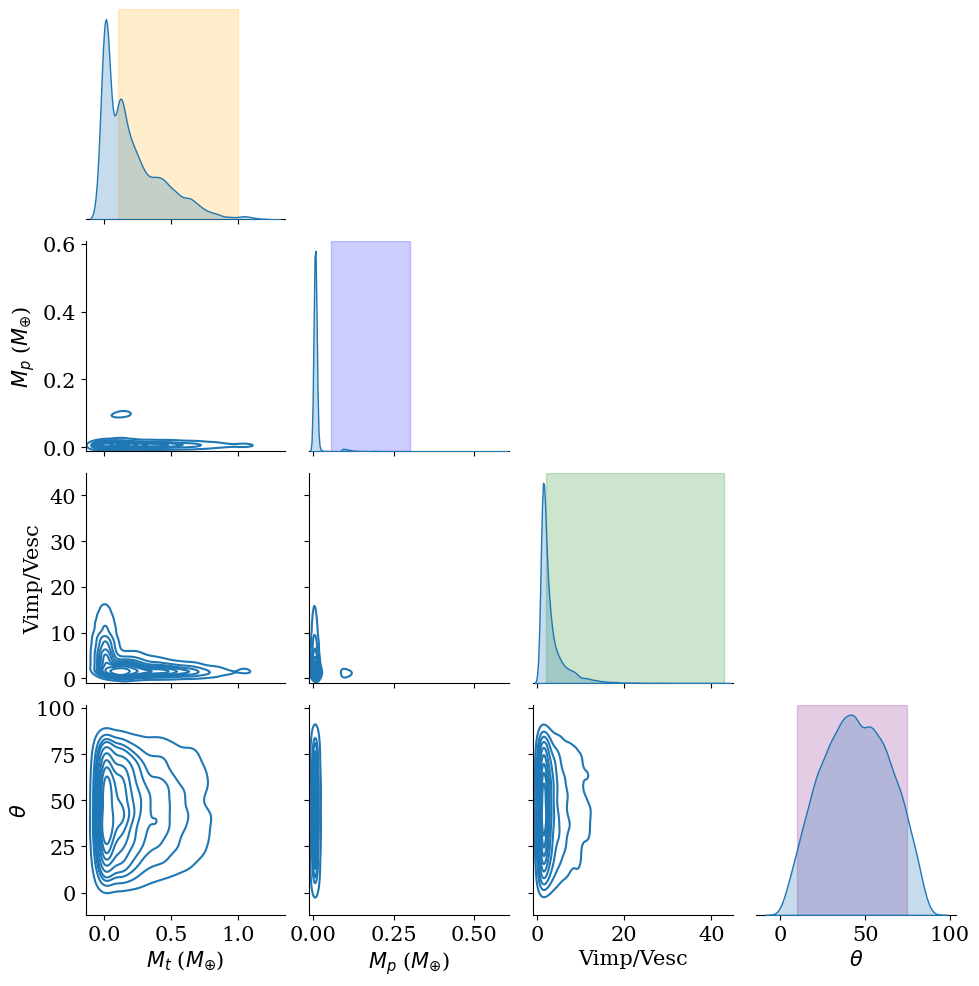

In [20]:
# Select the columns for the corner plot
corner_cols = ['Mt', 'Mp', 'Vimp/Vesc', 'theta']
custom_labels = [r"$M_{t}$ ($M_{\oplus}$)", r"$M_{p}$ ($M_{\oplus}$)", 'Vimp/Vesc', r'$\theta$']


# Drop rows with NaN in these columns to avoid plotting issues
plot_df = coll_stats_df[corner_cols].dropna()

# After your pairplot code
g = sns.pairplot(
    plot_df,
    corner=True,
    kind='kde',
    diag_kind="kde",
)
# Overlay vertical/horizontal lines for ranges
axes = g.axes

axes[0,0].axvspan(Mt_range[0], Mt_range[1], color='orange', alpha=0.2, label='Mt_range')
axes[1,1].axvspan(Mp_range[0], Mp_range[1], color='blue', alpha=0.2, label='Mp_range')
axes[2,2].axvspan(Vi_range[0], Vi_range[1], color='green', alpha=0.2, label='Vi_range')  # single value
axes[3,3].axvspan(theta_range[0], theta_range[1], color='purple', alpha=0.2, label='theta_range')
# Set axis labels
for i, label in enumerate(custom_labels):
    g.axes[i,0].set_ylabel(label)
    g.axes[-1,i].set_xlabel(label)

# Optionally add legends
#for i, ax in enumerate(np.diag(axes)):
#    ax.legend()
plt.savefig('cornerplot.pdf', dpi=300)
plt.show()

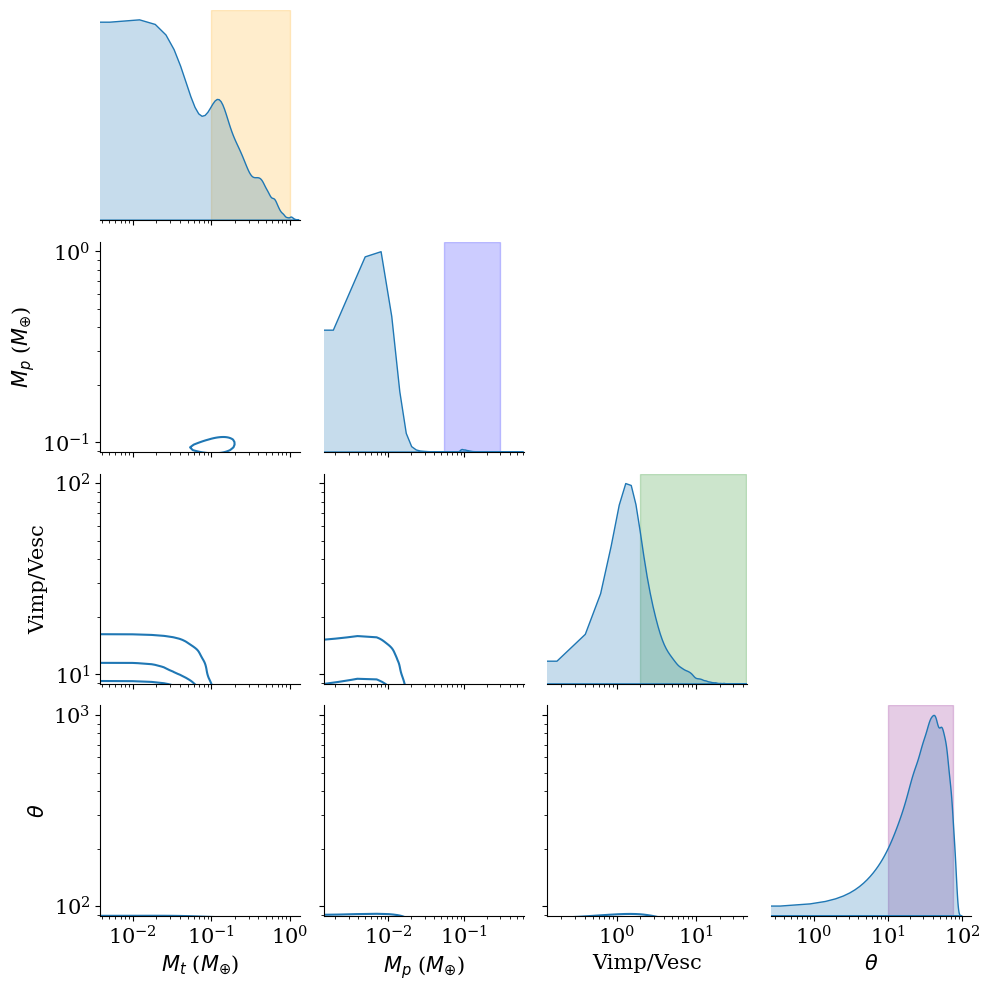

In [21]:
# ...existing code...

# After your pairplot code
g = sns.pairplot(
    plot_df,
    corner=True,
    kind='kde',
    diag_kind="kde",
)
# Overlay vertical/horizontal lines for ranges
axes = g.axes

axes[0,0].axvspan(Mt_range[0], Mt_range[1], color='orange', alpha=0.2, label='Mt_range')
axes[1,1].axvspan(Mp_range[0], Mp_range[1], color='blue', alpha=0.2, label='Mp_range')
axes[2,2].axvspan(Vi_range[0], Vi_range[1], color='green', alpha=0.2, label='Vi_range')  # single value
axes[3,3].axvspan(theta_range[0], theta_range[1], color='purple', alpha=0.2, label='theta_range')
# Set axis labels
for i, label in enumerate(custom_labels):
    g.axes[i,0].set_ylabel(label)
    g.axes[-1,i].set_xlabel(label)

# Set log scale for all axes
n = len(axes)
for row in range(n):
    for col in range(n):
        if axes[row, col] is not None:
            axes[row, col].set_xscale('log')
            axes[row, col].set_yscale('log')

plt.show()

In [9]:
# Define boolean mask for all ranges
mask = (
    (coll_stats_df['Mt'] >= Mt_range[0]) & (coll_stats_df['Mt'] <= Mt_range[1]) &
    (coll_stats_df['Mp'] >= Mp_range[0]) & (coll_stats_df['Mp'] <= Mp_range[1]) &
    (coll_stats_df['Vimp/Vesc'] >= Vi_range[0]) & (coll_stats_df['Vimp/Vesc'] <= Vi_range[1]) &
    (coll_stats_df['theta'] >= theta_range[0]) & (coll_stats_df['theta'] <= theta_range[1])
)

# Count how many rows fall within all ranges
n_in_ranges = mask.sum()
n_total = len(coll_stats_df)

print(f"{n_in_ranges} out of {n_total} rows fall within all specified")
print(f"That corresponds to {n_in_ranges/n_total * 100}%")

9 out of 10684 rows fall within all specified
That corresponds to 0.08423811306626731%


In [10]:
# Define boolean mask for all ranges
mask_all_else = (
    (coll_stats_df['Mt'] >= Mt_range[0]) & (coll_stats_df['Mt'] <= Mt_range[1]) &
    (coll_stats_df['Vimp/Vesc'] >= Vi_range[0]) & (coll_stats_df['Vimp/Vesc'] <= Vi_range[1]) &
    (coll_stats_df['theta'] >= theta_range[0]) & (coll_stats_df['theta'] <= theta_range[1])
)

# Count how many rows fall within all ranges
n_in_ranges = mask_all_else.sum()
n_total = len(coll_stats_df)

print(f"{n_in_ranges} out of {n_total} rows fall within all specified")
print(f"That corresponds to {n_in_ranges/n_total * 100}%")

2108 out of 10684 rows fall within all specified
That corresponds to 19.730438038187945%


In [11]:
# Define boolean mask for all ranges
mask_mp = (
    (coll_stats_df['Mp'] >= Mp_range[0]) & (coll_stats_df['Mp'] <= Mp_range[1])
)

# Count how many rows fall within all ranges
n_in_ranges = mask_mp.sum()
n_total = len(coll_stats_df)

print(f"{n_in_ranges} out of {n_total} rows fall within all specified")
print(f"That corresponds to {n_in_ranges/n_total * 100}%")

361 out of 10684 rows fall within all specified
That corresponds to 3.378884312991389%


In [12]:
coll_stats_df['type'].unique()

array(['GRAZE AND MERGE', 'EFFECTIVELY MERGED', 'ELASTIC BOUNCE',
       'SIMPLY MERGED', 'SUPER-CATASTROPHIC', 'PARTIAL ACCRETION',
       'GRAZING PARTIAL EROSION', 'PARTIAL EROSION', 'HIT AND RUN'],
      dtype=object)

In [13]:
coll_stats_non_merging = coll_stats_df[coll_stats_df['Vimp/Vesc'] > 2]

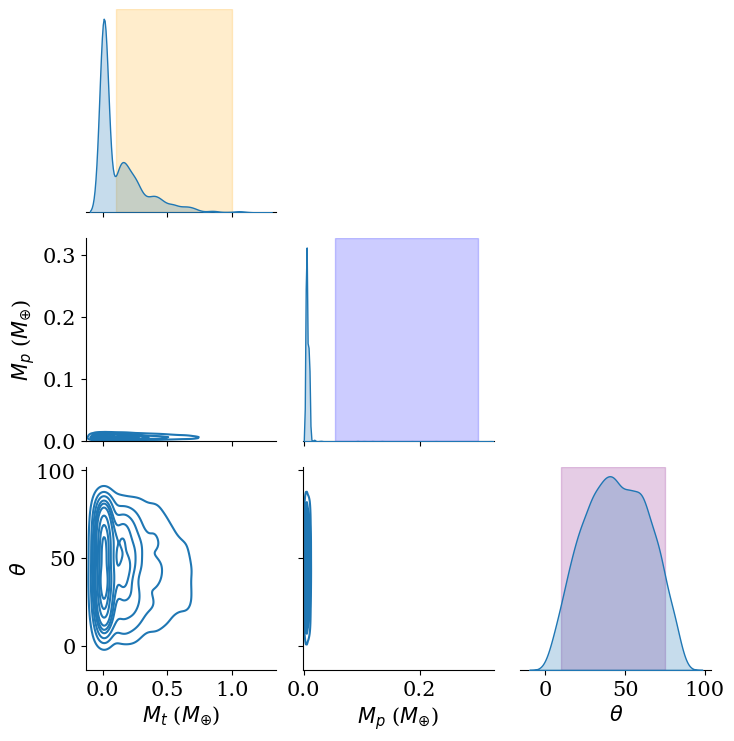

In [14]:
# Select the columns for the corner plot
corner_cols = ['Mt', 'Mp', 'theta']
custom_labels = [r"$M_{t}$ ($M_{\oplus}$)", r"$M_{p}$ ($M_{\oplus}$)", r'$\theta$']


# Drop rows with NaN in these columns to avoid plotting issues
plot_df = coll_stats_non_merging[corner_cols].dropna()

# After your pairplot code
g = sns.pairplot(
    plot_df,
    corner=True,
    kind='kde',
    diag_kind="kde",
)
# Overlay vertical/horizontal lines for ranges
axes = g.axes

axes[0,0].axvspan(Mt_range[0], Mt_range[1], color='orange', alpha=0.2, label='Mt_range')
axes[1,1].axvspan(Mp_range[0], Mp_range[1], color='blue', alpha=0.2, label='Mp_range')
#axes[2,2].axvspan(Vi_range[0], Vi_range[1], color='green', alpha=0.2, label='Vi_range')  # single value
axes[2,2].axvspan(theta_range[0], theta_range[1], color='purple', alpha=0.2, label='theta_range')
# Set axis labels
for i, label in enumerate(custom_labels):
    g.axes[i,0].set_ylabel(label)
    g.axes[-1,i].set_xlabel(label)

# Optionally add legends
#for i, ax in enumerate(np.diag(axes)):
#    ax.legend()
plt.savefig('cornerplot.pdf', dpi=300)
plt.show()

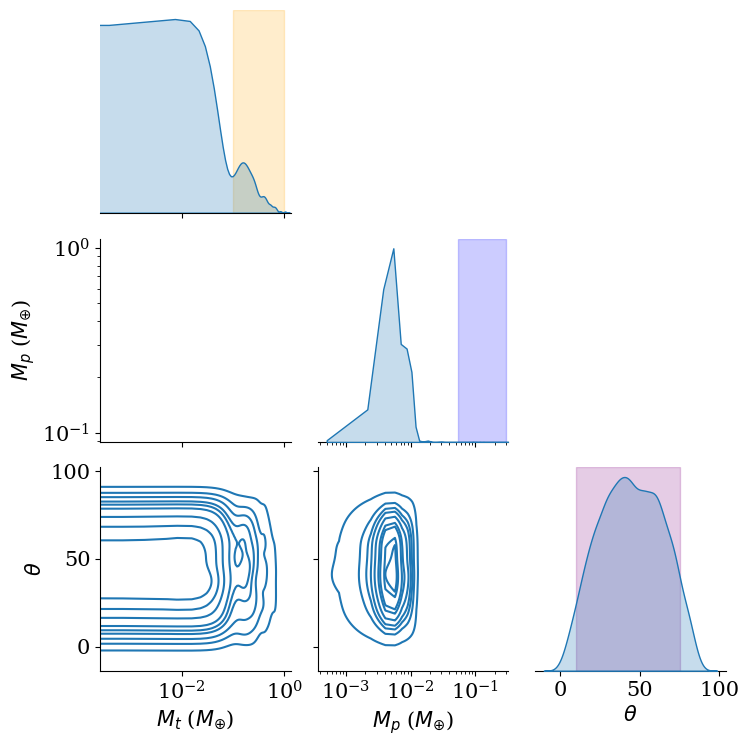

In [17]:
# ...existing code...

# After your pairplot code
g = sns.pairplot(
    plot_df,
    corner=True,
    kind='kde',
    diag_kind="kde",
)
# Overlay vertical/horizontal lines for ranges
axes = g.axes

axes[0,0].axvspan(Mt_range[0], Mt_range[1], color='orange', alpha=0.2, label='Mt_range')
axes[1,1].axvspan(Mp_range[0], Mp_range[1], color='blue', alpha=0.2, label='Mp_range')
#axes[2,2].axvspan(Vi_range[0], Vi_range[1], color='green', alpha=0.2, label='Vi_range')  # single value
axes[2,2].axvspan(theta_range[0], theta_range[1], color='purple', alpha=0.2, label='theta_range')
# Set axis labels
for i, label in enumerate(custom_labels):
    g.axes[i,0].set_ylabel(label)
    g.axes[-1,i].set_xlabel(label)

# Set log scale for Mt and Mp axes
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')

# Optionally add legends
#for i, ax in enumerate(np.diag(axes)):
#    ax.legend()
plt.savefig('cornerplot_log.pdf', dpi=300)
plt.show()

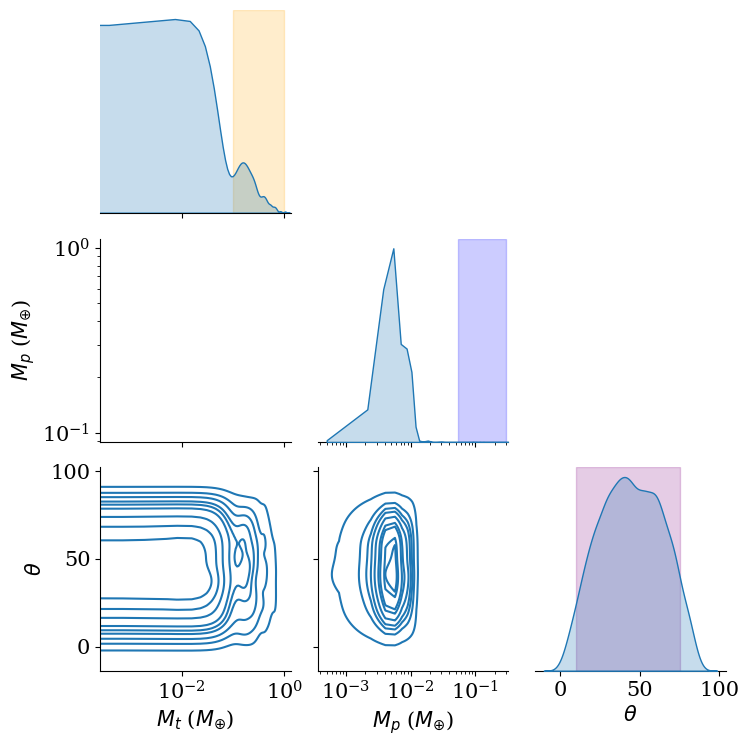

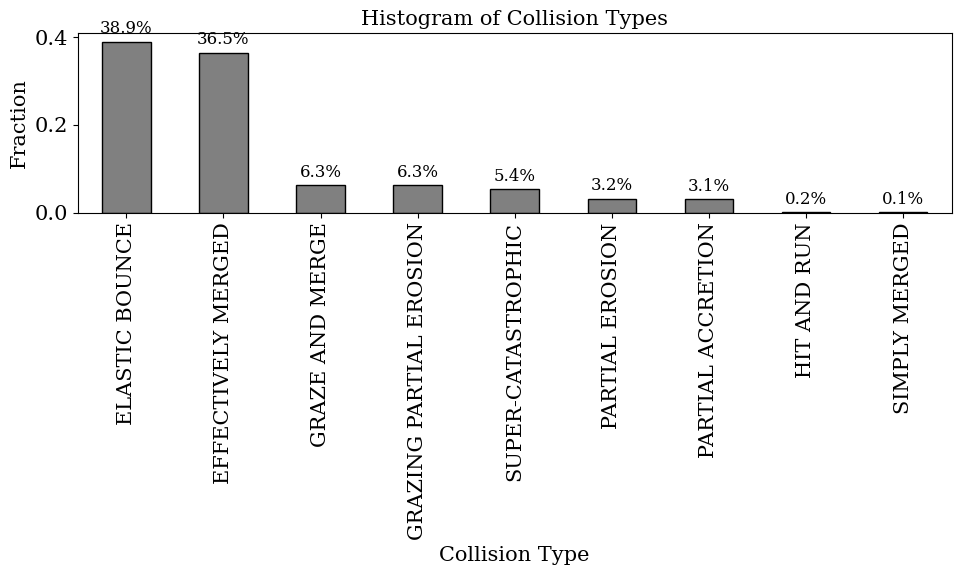

In [16]:
type_counts = coll_stats_df['type'].value_counts()
type_percent = type_counts / len(coll_stats_df)

plt.figure(figsize=(10,6))
type_percent.plot(kind='bar', color='gray', edgecolor='black')
plt.xlabel('Collision Type')
plt.ylabel('Fraction')
plt.title('Histogram of Collision Types')

# Annotate bars with percentages
for i, (count, percent) in enumerate(zip(type_percent, type_percent)):
    plt.text(i, count + 0.01, f"{percent * 100:.1f}%", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()